# Logistic Regression for churn prediction

We've decided to use logistic regression because it's a common model for classification tasks that is both simple and robust. It's quite easy to explain and easy to do regularization for it. It doesn't tend to overfitting, too. Therefore, it's the ideal baseline model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, precision_score, precision_recall_curve, accuracy_score
from myfunctions import prediction_matrices, save_metrics

import warnings
warnings.filterwarnings("ignore")

First, we load the final DataFrame from notebook 4.

In [2]:
df_train = pd.read_pickle('./data/df_train.pkl')
df_test = pd.read_pickle('./data/df_test.pkl')

# Assign Target and Features

In [3]:
X_train = df_train.drop("churn_risk_score", axis = 1)
y_train = df_train["churn_risk_score"]

X_test = df_test.drop("churn_risk_score", axis = 1)
y_test = df_test["churn_risk_score"]

Convert target into integer for compatibility of models

In [4]:
#df_train = df_train.astype(float)
y_train = y_train.astype(int)

y_test = y_test.astype(int)

# Logistic Regression

In [5]:
# Instatiate model and fit on train data

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Predict on test-data
y_pred = logreg.predict(X_test)

## Prediction scores and matrices

Report on train set : 
               precision    recall  f1-score   support

           0       0.84      0.82      0.83     12798
           1       0.85      0.87      0.86     14972

    accuracy                           0.85     27770
   macro avg       0.85      0.85      0.85     27770
weighted avg       0.85      0.85      0.85     27770

--------------------------------------------------------------------------------
Accuracy on test set: 0.86
ROC on test set: 0.95
Report on test set : 
               precision    recall  f1-score   support

           0       0.86      0.81      0.84      3167
           1       0.85      0.89      0.87      3779

    accuracy                           0.86      6946
   macro avg       0.86      0.85      0.85      6946
weighted avg       0.86      0.86      0.86      6946



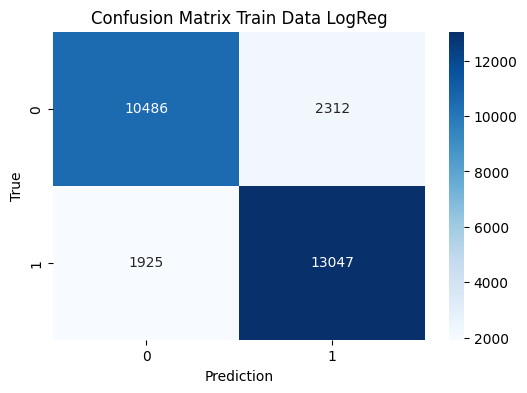

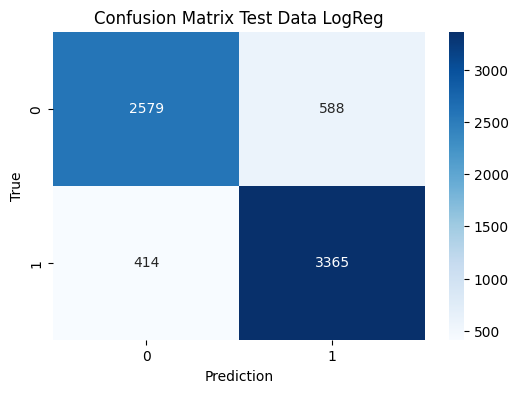

In [6]:
prediction_matrices(model = logreg, X_test = X_test, X_train= X_train, y_test= y_test, y_train = y_train, model_name= "LogReg")

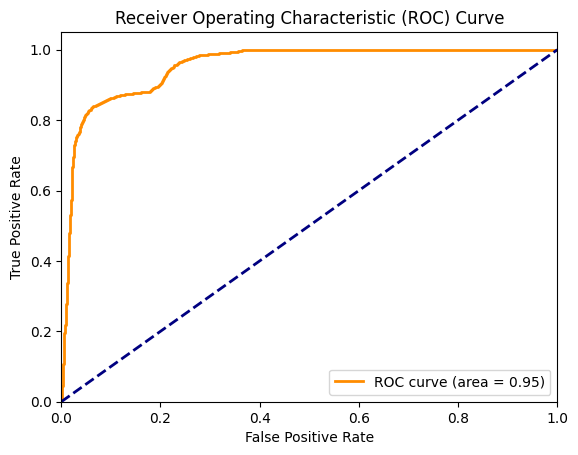

In [7]:
# ROC Curve
y_pred_roc = logreg.predict_proba(X_test)[:, 1] # Probability of positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)
roc_auc = roc_auc_score(y_test, y_pred_roc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



## Score evaluation

All scores for prediction on train and test data are in a very similar range indicating that there is no obvious overfitting. Most scores are usually around 85%. Moreover, similar values for precision and recall indicate a balanced prediction accuracy for both predictable classes. 

The ROC is a graphical representation of the performance of a classification model across different thresholds. We achieve a high score for ROC AUC with 95%. Taking a look on the curve, we noticed a plateau for TPR (approx. 0.85) for a FPR range from 0.1 - 0.2 and a 'jump' towards 1 beyond 0.2. This indicates a steep improvement of the model performance above a FPR of 0.2. 

What is next? Since the curve represents TPR and FPR for different thresholds, we can change the threshold to tune scores like accuracy, precision, recall (and F1) according to the stakeholder´s needs. 

To find the best threshold mathematical we use two approaches:
1. Youden Index 
2. F1 score

If your goal is to maximize both recall (TPR) and specificity (TNR) equally, you can use the Youden Index. If your goal is to find a balance between precision and recall, you can use the F1 Score.


In [8]:
# acknowledgements go to https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

#thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

# calculate score for each threshold
f1scores = [f1_score(y_test, to_labels(y_pred_roc, t)) for t in thresholds]
recall = [recall_score(y_test, to_labels(y_pred_roc, t)) for t in thresholds]
precision = [precision_score(y_test, to_labels(y_pred_roc, t)) for t in thresholds]
accuracy = [accuracy_score(y_test, to_labels(y_pred_roc, t)) for t in thresholds]

# Youden’s J statistic
# basically max TPR for min FPR
J = tpr - fpr
ixJ = np.argmax(J)
best_thresh_J = thresholds[ixJ]

# get best threshold
print("Scores for Youden's statistics:")
print("________________________________")
print('Threshold=%.3f, F1-Score=%.3f' % (best_thresh_J, f1scores[ixJ]))
print('Precision=%.3f, Recall=%.3f, Accuracy = %.3f' % (precision[ixJ], recall[ixJ], accuracy[ixJ]))
print('')
print('')

# Find best F1 score
ixF1 = np.argmax(f1scores)
best_thresh_F1 = thresholds[ixF1]
print("Scores for maximized F1_score:")
print("________________________________")
print('Threshold=%.3f, F1-Score=%.3f' % (thresholds[ixF1], f1scores[ixF1]))
print('Precision=%.3f, Recall=%.3f, Accuracy = %.3f' % (precision[ixF1], recall[ixF1], accuracy[ixF1]))
print('')
print('')

# Standard score
print("Scores for standard threshold")
print("________________________________")
print('Threshold= 0.5, F1-Score=%.3f' % (f1_score(y_test, y_pred)))
print('Precision=%.3f, Recall=%.3f, Accuracy = %.3f' % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy_score(y_test, y_pred)))



Scores for Youden's statistics:
________________________________
Threshold=0.679, F1-Score=0.887
Precision=0.939, Recall=0.840, Accuracy = 0.883


Scores for maximized F1_score:
________________________________
Threshold=0.312, F1-Score=0.892
Precision=0.829, Recall=0.965, Accuracy = 0.873


Scores for standard threshold
________________________________
Threshold= 0.5, F1-Score=0.870
Precision=0.851, Recall=0.890, Accuracy = 0.856


More on the different thresholds will be discussed in notebook 07_conclusion in regard to the business case.

### Visualization of the Scores vs. Thresholds
Show the maximum peaks and course of the scores

Text(0, 0.5, 'Scores')

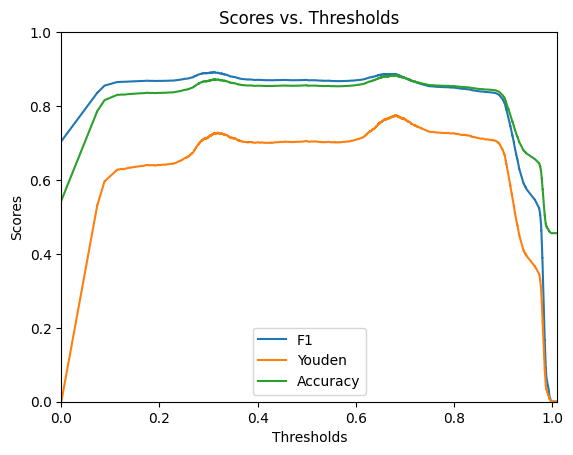

In [9]:
# Plot scores vs. thresholds
plt.plot(thresholds, f1scores, label='F1')
plt.plot(thresholds, J, label='Youden')
plt.plot(thresholds, accuracy, label='Accuracy')
#plt.plot(thresholds, precision, label='Precison')
#plt.plot(thresholds, recall, label='Recall')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.0])
plt.legend()
plt.title('Scores vs. Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Scores')

Unlike our first estimate, the best point is below a FPR of 0.2. Mathematically, it seems to be more efficient to allow a lower TPR for a smaller FPR.

Now let's tune precision and recall dependent on the set threshold:

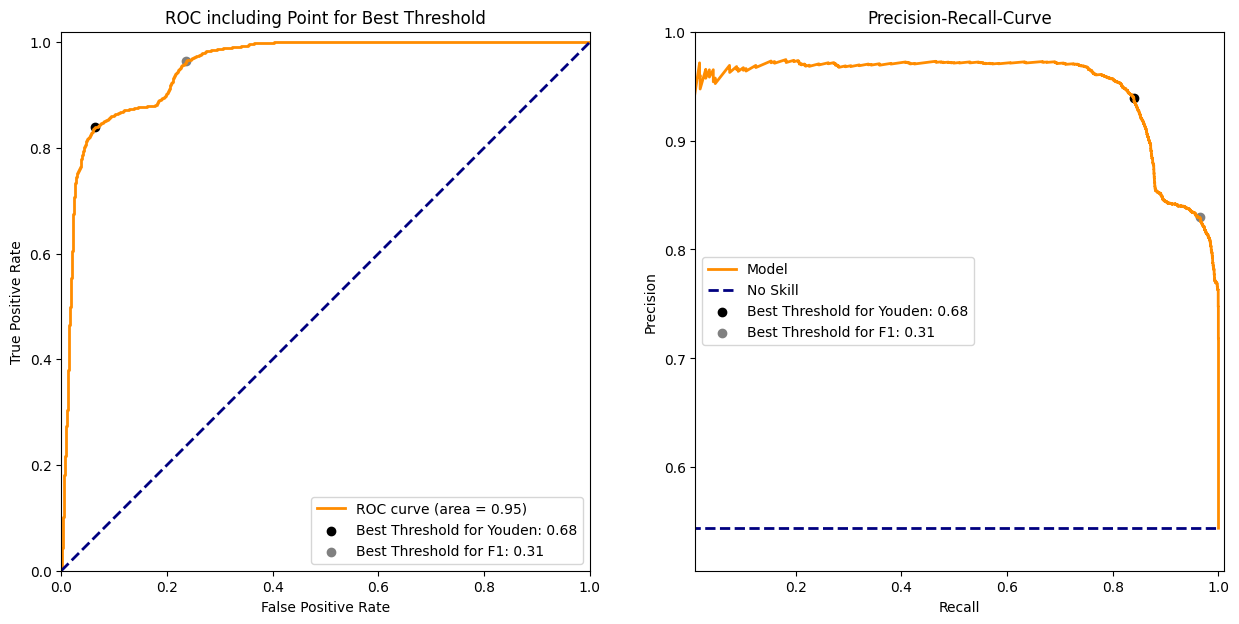

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot ROC curve including best threshold for Youden's statistics
axes[0].set_title('ROC including Point for Best Threshold')


#plt.figure(figsize=[5,5])
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].scatter(fpr[ixJ], tpr[ixJ], marker='o', color='black', label=f'Best Threshold for Youden: {best_thresh_J.round(2)}')
axes[0].scatter(fpr[ixF1], tpr[ixF1], marker='o', color='grey', label=f'Best Threshold for F1: {best_thresh_F1.round(2)}')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.02])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')

axes[0].legend(loc="lower right")

# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)

#set title
axes[1].set_title("Precision-Recall-Curve")
axes[1].plot(recall, precision, color='darkorange', lw=2, label='Model')
axes[1].plot([0,1], [no_skill,no_skill], color='navy', lw=2, linestyle='--', label='No Skill')
axes[1].scatter(recall[ixJ], precision[ixJ], marker='o', color='black', label=f'Best Threshold for Youden: {best_thresh_J.round(2)}')
axes[1].scatter(recall[ixF1], precision[ixF1], marker='o', color='grey', label=f'Best Threshold for F1: {best_thresh_F1.round(2)}')


# axis labels
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')

#set lim
axes[1].set_xlim((0.01,1.01))
axes[1].set_ylim((0.505,1))
axes[1].legend()
# show the plot
plt.show()

## Save Model

In [11]:
# Save model
with open('./model/model_logreg.pkl', 'wb') as file:
    pickle.dump(logreg, file)

## Feature Importance for one-hot encoded Features

Feature Importance:
                                        Feature  Importance
31                    feedback_Reasonable Price    3.963418
33               feedback_User Friendly Website    3.955433
29            feedback_Products always in Stock    3.818006
30               feedback_Quality Customer Care    3.772606
34                          membership_category    1.531573
4                              points_in_wallet    0.450636
25                    complaint_status_Unsolved    0.177564
27                feedback_Poor Product Quality    0.169683
22              complaint_status_Not Applicable    0.139844
8                                gender_Unknown    0.127142
23                      complaint_status_Solved    0.095844
26               feedback_Poor Customer Service    0.095051
24         complaint_status_Solved in Follow-up    0.080989
15         preferred_offer_types_Without Offers    0.074525
32                        feedback_Too many ads    0.073330
20                  

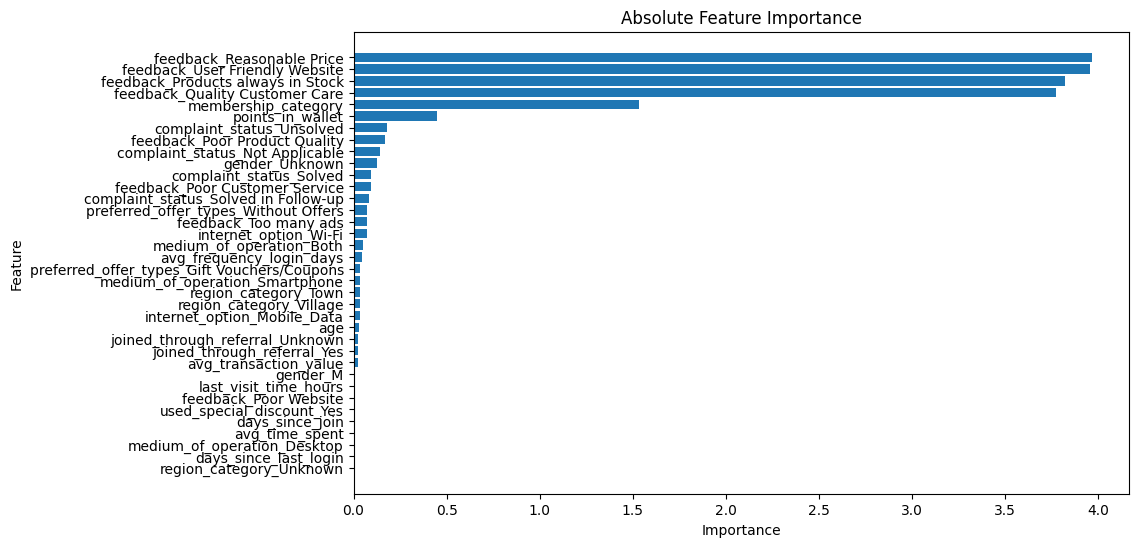

In [12]:
# Read coefficents of logistic regression which contain the feature importance of this model
coefficients = logreg.coef_[0]

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': coefficients
})
# Get absolute feature importance
feature_importance_abs = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(coefficients)
})
# Sort absolut feature importance in descending order
feature_importance_abs = feature_importance_abs.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance_abs)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_abs['Feature'], feature_importance_abs['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Absolute Feature Importance')
plt.gca().invert_yaxis()  # invert axis for most importance feature at top
plt.show()

We used the absolute value of the optimized coefficients to get an estimate of the importance of each one-hot encoded feature. We decided to show the absolute feature importance. However, some values are originally negative and reflect a tendency towards prediction churn 0 or churn 1. Interestingly according to this analysis, especially feedback seems to have a very high importance for the decision of a customer to churn. Other important features seem to be the membership_category and points_in_wallet.

**Limitation**
To avoid multicolinearity, we decided to use "drop_first" to drop one column for each one-hot encoded original feature. Therefore, the list of one-hot encoded features does not represent all possible feature values. However, their values may include an implicit importance of the dropped one-hot encoded feature. Especially feature importance of categorical features with very few values might be distorted by this.

Moreover, the feature importance shown here is independent on the relative proportion for the whole population. For instance, gender_Unknown gets a relatively high feature importance but only represents a population far below 1%.

## Summarizing feature importance for the original feature

To get a better understanding for the overall importance of a feature, we need to summarize all one-hot encoded features to get an estimate of the importance of the original feature. In fact, the one-hot encoded features actually represent the values of the original feature and not the original variable itself. Furthermore, the one-hot encoded features belonging to the same original feature may be positive or negative. If just using 'sum' for summarizing, we might lose information since those features may cancel each other out. 

Therefore, we
1. convert all importances to absolute values;
2. trunc the names of the one-hot encoded feature names to the original feature name;
3. use the original feature name to group the importance as sum to get an estimate of the overall importance

**Limitations**
We stress that this approach just gives an estimate of the overall importance for a specific feature. For instance, for some one-hot encoded features (and by that the feature values) might get a high importance but only represent a small portion of the whole population. Alternatives might include a weighted sum where each value would be weighted according to their relative proportion in the whole population.

In [13]:
#get the original variable names
original_features = pd.read_pickle('./data/df_train_KNN.pkl')
original_features.drop('churn_risk_score', axis=1, inplace=True)
original_features = original_features.columns
print(original_features) 

Index(['age', 'gender', 'region_category', 'membership_category',
       'joined_through_referral', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'days_since_last_login',
       'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet', 'used_special_discount', 'complaint_status',
       'feedback', 'last_visit_time_hours', 'days_since_join'],
      dtype='object')


In [14]:
#overwrite one-hot encoded feature name with original feature name
#this will allow us to group by original feature for summarization in a next step
for feature in feature_importance["Feature"]:
   for original in original_features:
      if feature.startswith(original):
         feature_importance["Feature"][feature_importance["Feature"] == feature]= original

feature_importance

,Feature,Importance
0,age,0.029950
1,avg_time_spent,0.002538
2,avg_transaction_value,-0.022721
3,avg_frequency_login_days,0.045413
4,points_in_wallet,-0.450636
5,last_visit_time_hours,0.008205
6,days_since_join,-0.004348
7,gender,0.009352
8,gender,-0.127142
9,region_category,-0.034390


In [15]:
#get absolute values for importance
feature_importance["Importance"] = feature_importance["Importance"].apply(lambda x: np.abs(x))

#sum importance grouped by each original feature
original_feature_importances = feature_importance.groupby("Feature")\
        .sum()\
        .sort_values(by = "Importance", ascending= False)\
        .reset_index()

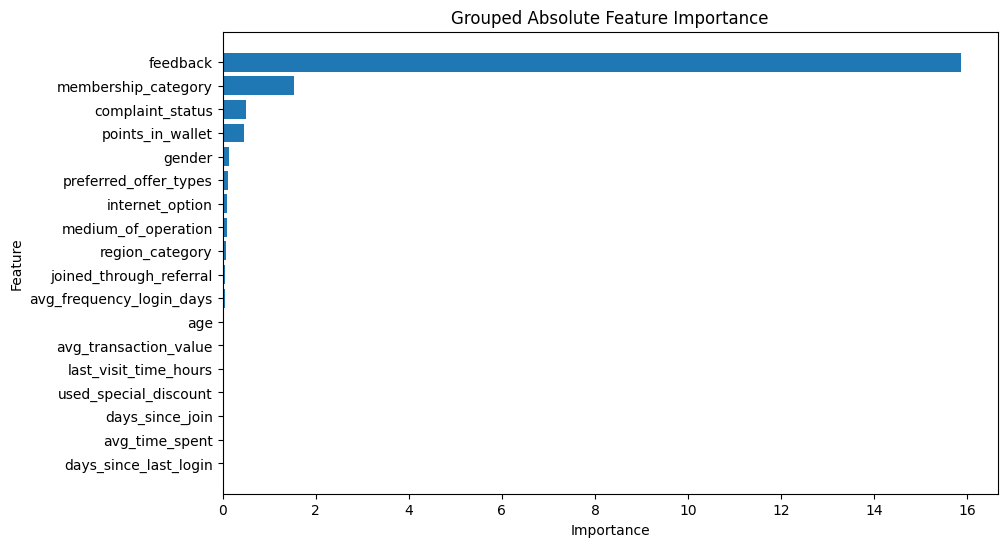

In [16]:
plt.figure(figsize=(10, 6))
plt.barh(original_feature_importances['Feature'], original_feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Grouped Absolute Feature Importance')
plt.gca().invert_yaxis()  # Umkehr der Achsen, damit die wichtigsten Features oben sind
plt.show()

Similar to the feature importnace of the one-hot encoded features, the importance of the grouped features is dominated by 'feedback' followed by 'membership_category' and 'points_in_wallet'. The same limitaions apply.

## Save predictions for error analysis in '06_01_evaluation...'

In [17]:
# create a data set with the predicted values for evaluation of test-data:
df_test_eval = df_test.copy()
y_pred = logreg.predict(X_test)
df_test_eval['y_pred'] = y_pred

In [18]:
# create a data set with the predicted values for evaluation of  train-test:
df_train_eval = df_train.copy()
y_pred_train = logreg.predict(X_train)
df_train_eval['y_pred'] = y_pred_train

In [19]:
# check if subfolder exists:
if not os.path.exists('./data/eval'):
        os.makedirs('./data/eval')

# write the dataframes with prediction outcome for next notebook 
df_train_eval.to_pickle('./data/eval/df_train_eval.pkl')
df_test_eval.to_pickle('./data/eval/df_test_eval.pkl')

## Save metrics

In [20]:
# save metrics for Youden's
save_metrics('logreg_youden', 
            accuracy[ixJ], 
            precision[ixJ], 
            recall[ixJ], 
            f1scores[ixJ], 
            roc_auc,
            )

# save metrics for maximized F1
save_metrics('logreg_max_F1', 
            accuracy[ixF1], 
            precision[ixF1], 
            recall[ixF1], 
            f1scores[ixF1], 
            roc_auc,
            )

# save metrics for standard threshold
save_metrics('logreg_st_threshold', 
            accuracy_score(y_test, y_pred), 
            precision_score(y_test, y_pred), 
            recall_score(y_test, y_pred), 
            f1_score(y_test, y_pred), 
            roc_auc,
            )


df created
Metrics for logreg_youden saved successfully!
df loaded
Metrics for logreg_max_F1 saved successfully!
df loaded
Metrics for logreg_st_threshold saved successfully!


In [21]:
# Check df_metrics
df_metrics = pd.read_pickle('./data/df_metrics.pkl')
print(df_metrics)

                                   model  accuracy  precision    recall  \
logreg_youden              logreg_youden  0.883386   0.939331  0.839905   
logreg_max_F1              logreg_max_F1  0.872876   0.829390  0.964806   
logreg_st_threshold  logreg_st_threshold  0.855744   0.851252  0.890447   

                           F1   ROC_AUC  
logreg_youden        0.886840  0.953799  
logreg_max_F1        0.891988  0.953799  
logreg_st_threshold  0.870409  0.953799  
